In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
random.seed(0)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols:
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)
X_train_rf, X_test_rf, y_train_rf, y_test_rf, group_train_rf, group_test_rf = train_test_split(
    data_original, target, group, test_size=0.2, random_state=0)
X_test_rf.drop(columns=['target', 'PINCP'], inplace=True)
X_train_rf.drop(columns=['target', 'PINCP'], inplace=True)

In [2]:
# The details of our "example" person
cols

{'HINS1': 'HINS1_2.0',
 'HINS2': 'HINS2_2.0',
 'HINS4': 'HINS4_2.0',
 'CIT': 'CIT_1.0',
 'COW': 'COW_1.0',
 'SCHL': 'SCHL_16.0',
 'MAR': 'MAR_5.0',
 'SEX': 'SEX_1.0',
 'RAC1P': 'RAC1P_1.0',
 'ENG': 'ENG_1.0'}

### Reference Person Explanation
When encoding the discrete variables of our data. We chose the reference datapoint from Table: XX.
We chose to use this reference person as we assert this person is the "generic" american citizen in this case. <br>
| **Variable** | **Value** | **Reason** |
| --------- | -------- | --------- |
| HINS1 | 2 | As a rule, we assume that respondants don't have any form of insurance. |
| HINS2 | 2 | Same as above. |
| HINS4 | 2 | Same as above. | 
| CIT | 1 | We assume that respondants would be american-born. |
| COW | 1 | We find that working for a private for-profit company is the most "baseline" occupation. |
| SCHL | 16 | We set the reference as High school, since it fits nicely in the middle of the variable. | 
| MAR | 5 | Non-married as reference. Able to compare with the starting point in ones love life. |
| SEX | 1 | Male as reference. Slight majority in data. |
| ENG | 1 | Use very well english speaking as reference, since the country is english speaking natively.|


The overall though process for choosing the reference variables was to choose the variables which best capture the picture of the "ideal average" citizen in the dataset. <br>
We use min-max scaling on the "AGEP" variable, to ensure that our logistic regression model converges within a reasonable time-frame. <br>
In terms of model parameters we copied the Logistic regression parameters from exercise 2 and found that they work quite well for this project. The Random Forest is in initialized with 100 estimators and a max depth of 10. With these parameters we strike a balance between a lightweight tree model and still having the model be complex enough that it stays black-box. <br>


In [3]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2, rf):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    X_test = X_test.reset_index(drop=True)
    if not rf:
        s2 = X_test.loc[X_test['SEX_2.0'] == True] 
        s1 = X_test.loc[X_test['SEX_2.0'] == False]
    if rf:
        s1 = X_test.loc[X_test['SEX'] == 1]
        s2 = X_test.loc[X_test['SEX'] == 2]

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])

    if not rf:
        scores_s1 = pipeline.predict_proba(s1)[:, 1]
        fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
        scores_s2 = pipeline.predict_proba(s2)[:, 1]
        fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)
    if rf:
        scores_s1 = pipeline.predict_proba(s1)[:, 1]
        fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1)
        scores_s2 = pipeline.predict_proba(s2)[:, 1]
        fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2)

    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [5]:
def minimize_odd_diff(true_s1, true_s2, scores_1, scores_2, k):
    x = np.linspace(0, 1, k)
    fpr_diff = []
    tpr_diff = []
    accuracies_1 = []
    accuracies_2 = []
    best_vals = {'threshold' : None, 'diff' : 1}
    counter = 0
    for idx, i1 in enumerate(x):
        for idxx, i2 in enumerate(x):    
            preds_s1 = scores_1 >= i1
            preds_s2 = scores_2 >= i2
            tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
            tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()
            fpr1 = fp1 / (fp1 + tn1)
            tpr1 = tp1 / (tp1 + fn1)
            fpr2 = fp2 / (fp2 + tn2)
            tpr2 = tp2 / (tp2 + fn2)
            fpr_diff.append(abs(fpr1 - fpr2))
            tpr_diff.append(abs(tpr1 - tpr2))
            accuracies_1.append(accuracy_score(preds_s1, true_s1))
            accuracies_2.append(accuracy_score(preds_s2, true_s2))
            if abs(tpr_diff[counter] - fpr_diff[counter]) < abs(best_vals['diff']):
                best_vals['diff'] = abs(tpr_diff[counter] - fpr_diff[counter])
                best_vals['threshold'] = [i1, i2]
            counter += 1
    return best_vals, tpr_diff, fpr_diff

In [6]:
# Needed to make sure logisric regression converges
scaler = MinMaxScaler()
X_train['AGEP'] = scaler.fit_transform(X_train[['AGEP']])
X_test['AGEP'] = scaler.transform(X_test[['AGEP']])

In [7]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = RandomForestClassifier(**rf_args)
p2 = lr_model

In [8]:
def stat_parity(preds_s1, preds_s2, s1, s2):
    parity = (np.sum(preds_s2)/len(s2)) / (np.sum(preds_s1)/len(s1))
    if parity > 1:
        parity = (np.sum(preds_s1)/len(s1)) / (np.sum(preds_s2)/len(s2))
        print('Group 2 is underrepresented by', parity)
    else:
        print('Group 1 is underrepresented by', parity)

def equalized_odds(tpr1, fpr1, tpr2, fpr2):
    fpr_diff = fpr1 / fpr2
    if fpr_diff > 1:
        fpr_diff = fpr2 / fpr1
        print('Group 2 is underrepresented by', fpr_diff, '(FPR)')
    else:
        fpr_diff = fpr1 / fpr2
        print('Group 1 is underrepresented by', fpr_diff, '(FPR)')
    tpr_diff = tpr1 / tpr2
    if tpr_diff > 1:
        tpr_diff = tpr2 / tpr1
        print('Group 2 is underrepresented by', tpr_diff, '(TPR)')
    else:
        tpr_diff = tpr1 / tpr2
        print('Group 1 is underrepresented by', tpr_diff, '(TPR)')

def equalized_outcomes(some_1, some_2, some_3, some4):
    p_diff = some_1 / some_2
    if p_diff > 1:
        p_diff = some_2 / some_1
        print('Group 2 is underrepresented by', p_diff, '(positives)')
    else:
        p_diff = some_1 / some_2
        print('Group 1 is underrepresented by', p_diff, '(positives)')
    n_diff = some_3 / some4
    if n_diff > 1:
        n_diff = some4 / some_3
        print('Group 2 is underrepresented by', n_diff, '(negatives)')
    else:
        n_diff = some_3 / some4
        print('Group 1 is underrepresented by', n_diff, '(negatives)')

In [9]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.5, 0.5, False)

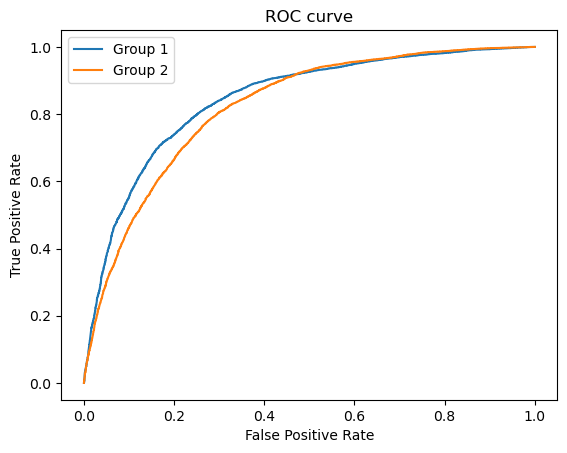

------------BEFORE BIAS ANALYSIS------------
Group 1 is underrepresented by 0.8055914916015838
Group 2 is underrepresented by 0.9161489128145933 (FPR)
Group 2 is underrepresented by 0.9082534362193185 (TPR)
Group 2 is underrepresented by 0.9074041126009066 (positives)
Group 1 is underrepresented by 0.9386142861973736 (negatives)
------------AFTER BIAS ANALYSIS------------
Group 1 is underrepresented by 0.7531681327043257
Group 1 is underrepresented by 0.9027869547637597 (FPR)
Group 2 is underrepresented by 0.9769648493638499 (TPR)
Group 2 is underrepresented by 0.9125353507335131 (positives)
Group 1 is underrepresented by 0.5743942777378636 (negatives)


In [10]:
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

stat_parity(preds_s1, preds_s2, s1, s2)


tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

best_vals, balls1, balls2 = minimize_odd_diff(true_s1=true_s1, true_s2=true_s2, scores_1= scores_s1,scores_2= scores_s2, k= 50)

preds_s1 = scores_s1 >= best_vals['threshold'][0]
preds_s2 = scores_s2 >= best_vals['threshold'][1]

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

equalized_odds(tpr1, fpr1, tpr2, fpr2)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

equalized_outcomes(some_1, some_2, some_3, some_4)

print('------------AFTER BIAS ANALYSIS------------')

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

stat_parity(preds_s1, preds_s2, s1, s2)

fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

equalized_odds(tpr_group1, fpr_group1, tpr_group2, fpr_group2)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

equalized_outcomes(some_1, some_2, some_3, some_4)

In [11]:
best_vals

{'threshold': [0.24489795918367346, 0.36734693877551017],
 'diff': 2.5950308061462035e-05}

In [12]:
X_train_rf['AGEP'] = scaler.transform(X_train_rf[['AGEP']])
X_test_rf['AGEP'] = scaler.transform(X_test_rf[['AGEP']])
p1_done = evaluate_pipeline(p1, X_train_rf, y_train_rf, X_test_rf, y_test_rf, 0.5, 0.5, True)

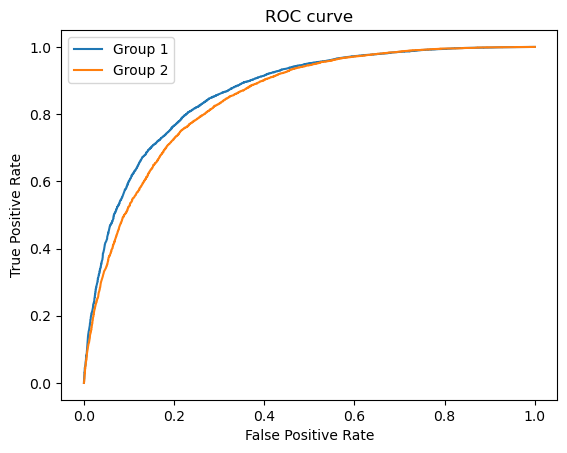

------------BEFORE BIAS ANALYSIS------------
Group 1 is underrepresented by 0.849544906895835
Group 2 is underrepresented by 0.8412564719473543 (FPR)
Group 2 is underrepresented by 0.9016614150239841 (TPR)
Group 2 is underrepresented by 0.9499672838696782 (positives)
Group 1 is underrepresented by 0.9638929534023567 (negatives)
------------AFTER BIAS ANALYSIS------------
Group 1 is underrepresented by 0.8334710853653557
Group 1 is underrepresented by 0.39250118652112004 (FPR)
Group 2 is underrepresented by 0.9500263612741876 (TPR)
Group 2 is underrepresented by 0.98198536911875 (positives)
Group 1 is underrepresented by 0.10976836294280942 (negatives)


In [13]:
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print('------------BEFORE BIAS ANALYSIS------------')

stat_parity(preds_s1, preds_s2, s1, s2)

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

best_vals, balls1, balls2 = minimize_odd_diff(true_s1=true_s1, true_s2=true_s2, scores_1= scores_s1,scores_2= scores_s2, k= 50)

preds_s1 = scores_s1 >= best_vals['threshold'][0]
preds_s2 = scores_s2 >= best_vals['threshold'][1]

# equalized odds (horizontal)
tpr1 = tp1 / (tp1 + fn1)
fpr1 = fp1 / (fp1 + tn1)
tpr2 = tp2 / (tp2 + fn2)
fpr2 = fp2 / (fp2 + tn2)

equalized_odds(tpr1, fpr1, tpr2, fpr2)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

equalized_outcomes(some_1, some_2, some_3, some_4)

print('------------AFTER BIAS ANALYSIS------------')

tn1, fp1, fn1, tp1 = confusion_matrix(preds_s1, true_s1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(preds_s2, true_s2).ravel()

stat_parity(preds_s1, preds_s2, s1, s2)

fpr_group1 = fp1 / (fp1 + tn1)
tpr_group1 = tp1 / (tp1 + fn1)
fpr_group2 = fp2 / (fp2 + tn2)
tpr_group2 = tp2 / (tp2 + fn2)

equalized_odds(tpr_group1, fpr_group1, tpr_group2, fpr_group2)

# equalized outcomes, given selection, groups have equal outcomes
some_1 = tp1 / (tp1 + fp1)
some_2 = tp2 / (tp2 + fp2)
some_3 = tn1 / (tn1 + fn1)
some_4 = tn2 / (tn2 + fn2)

equalized_outcomes(some_1, some_2, some_3, some_4)

In [14]:
best_vals

{'threshold': [0.04081632653061224, 0.14285714285714285],
 'diff': 1.2205730916148294e-05}

## Task 3: Model agnostic explainations with SHAP

Here we use model agnostic explainations with SHAP to explain both of the models. Summary of this section below:

 - Row chosen for comparison and printed
 - For Logistic Regression and then Random Forest:
    1. Calculate SHAP values
    2. Aggregate SHAP values according to one-hot encodings per feature
    3. Generate bar plot
    4. Generate beeswarm plot
    5. Generate force plot for specific row

In [15]:
# TODO: add to top of notebook during final cleanup
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Row chosen for comparison

Row chosen for comparison is 0th index of test set

In [16]:
specific_row_idx = 0
X_test.iloc[[specific_row_idx]]

,AGEP,HINS1_1.0,HINS1_nan,HINS2_1.0,HINS2_nan,HINS4_1.0,HINS4_nan,CIT_2.0,CIT_3.0,CIT_4.0,...,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
309375,0.584416,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Person is:

- 62 years of age
- Male
- Has some College, but less than 1 year
- Has insurance through a current or former employee

## Generating the plots

### Logistic Regression plots

#### Calculating shap values

In [18]:
lr_explainer = shap.Explainer(
    p2_done,
    X_train,
    feature_names=X_train.columns
    )

lr_shap_values = lr_explainer(X_test)

#### Aggregating one-hot encodings to be per-feature

In [19]:
# based on what features were onehot encoded get indices of rows that need to be aggregated
group_idx_list = list()
for i in feature_names:
    group_idx_list.append([n for n, l in enumerate(X_train.columns) if l.startswith(i)])

# for each row aggregate the shap values based on indices from group_idx_list and store them in shap_agg_full
shap_agg_full = np.zeros((lr_shap_values.shape[0], len(feature_names)))
for group_idx, group in enumerate(group_idx_list):
    shap_agg_full[:, group_idx] = np.sum(lr_shap_values[:, group].values, axis=1)

# to still have an explainer object we can copy and replace lr_shap_values
# having an explainer object is needed for bar & beeswarm plots
lr_shap_values_aggregated = lr_shap_values
lr_shap_values_aggregated.values = shap_agg_full
lr_shap_values_aggregated.data = lr_shap_values_aggregated.data[:, :len(feature_names)]
lr_shap_values_aggregated.values.shape
lr_shap_values_aggregated.feature_names = feature_names # shap_agg_full column order is the same as feature_names

#### Generating general bar and beeswarm plots

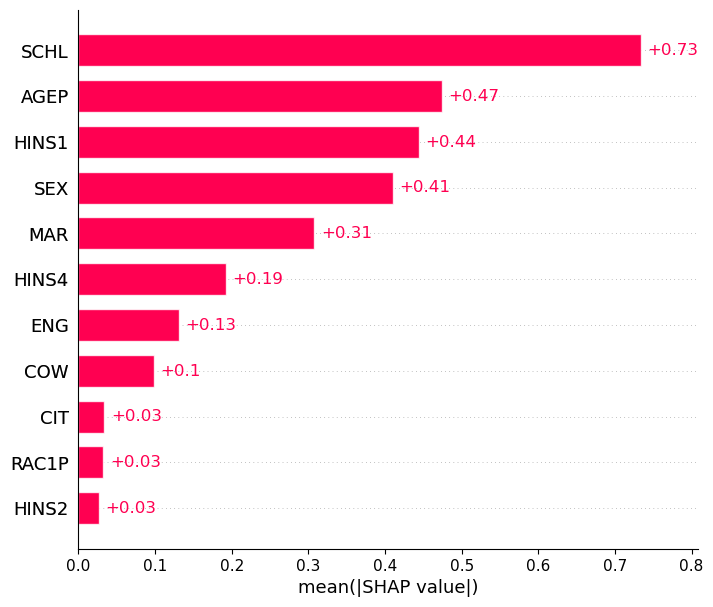

In [20]:
shap.plots.bar(lr_shap_values_aggregated, max_display=11)

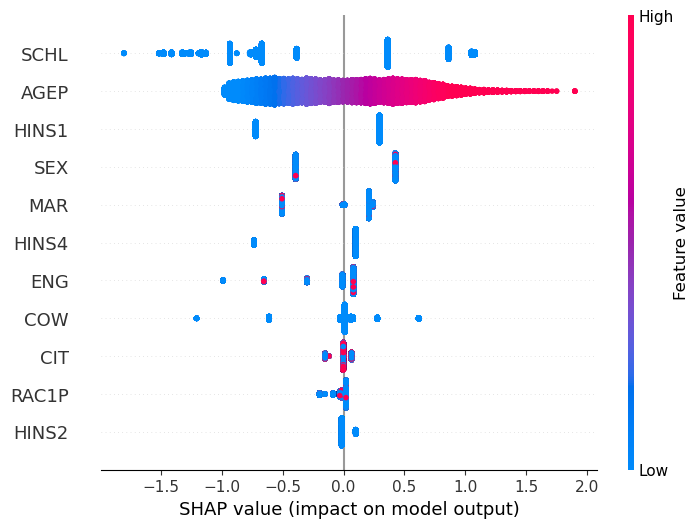

In [21]:
shap.plots.beeswarm(lr_shap_values_aggregated, max_display=11)

#### Generating row specific plot

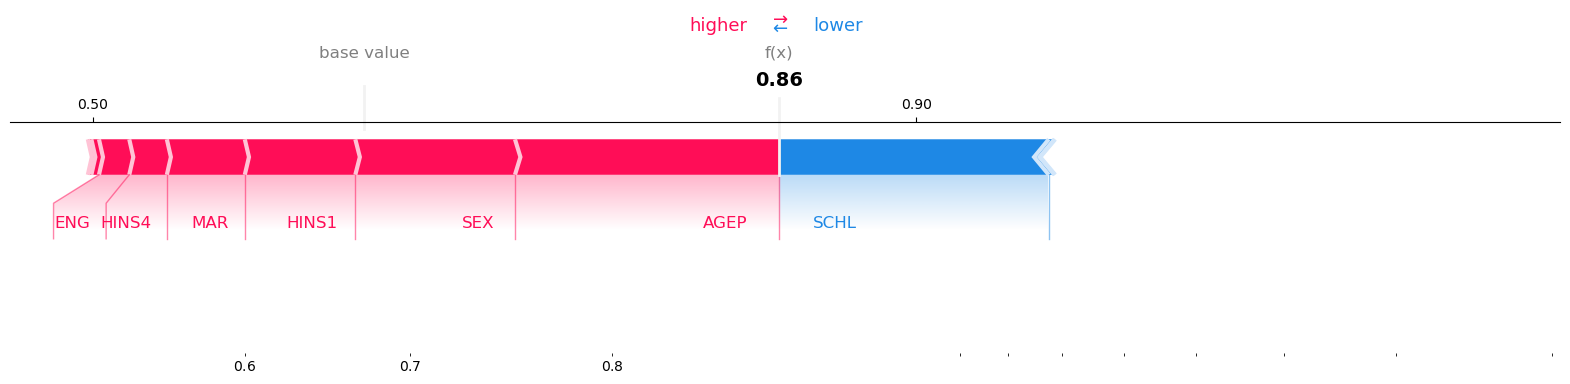

In [22]:
shap.force_plot(lr_explainer.expected_value, shap_agg_full[specific_row_idx], feature_names=feature_names, matplotlib=True, link='logit')

### Random Forest Plots

#### Calculating shap values - can take up to 30 minutes

In [24]:
rf_explainer = shap.Explainer(p1_done, X_train_rf, model_output='probability', feature_names=X_train_rf.columns)
rf_shap_values = rf_explainer(X_test_rf)

100%|===================| 78248/78266 [29:51<00:00]        

#### Generating general bar and beeswarm plots

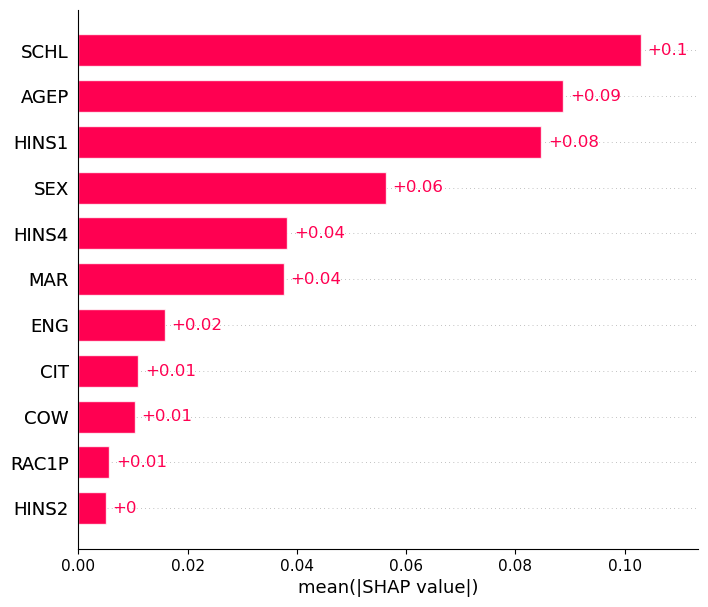

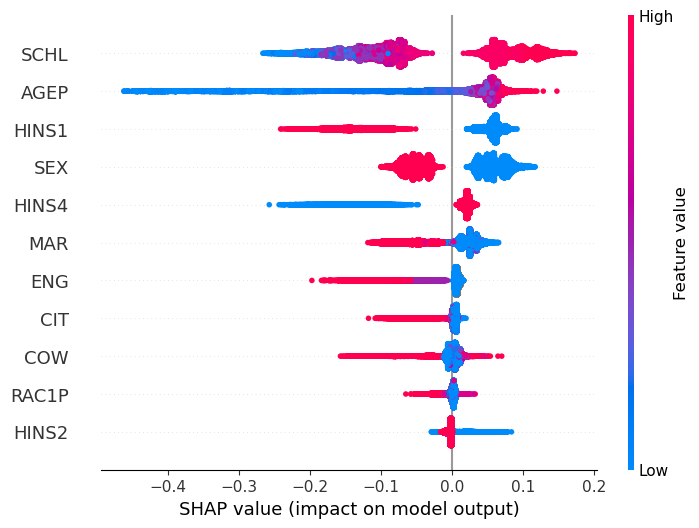

In [25]:
shap.plots.bar(rf_shap_values[:,:,1], max_display=11)
shap.plots.beeswarm(rf_shap_values[:,:,1], max_display=11)

#### Generating row specific plot

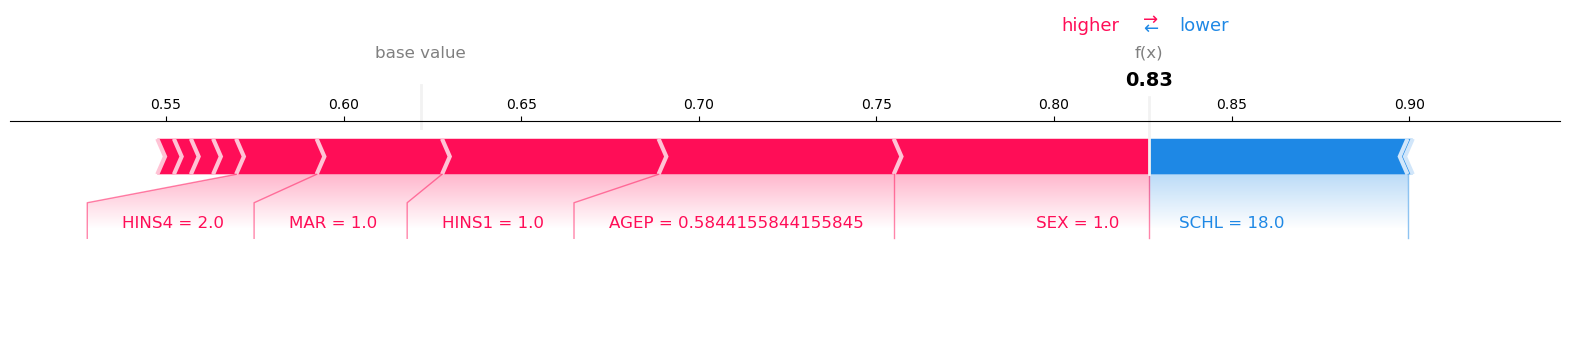

In [41]:
row_to_explain = X_test_rf.iloc[[specific_row_idx]]
row_shap_values = rf_explainer(row_to_explain)
shap.plots.force(rf_explainer.expected_value[1], row_shap_values.values[:, :, 1], row_to_explain, feature_names=X_train_rf.columns, matplotlib=True)